# Python framework class for Cy-RSoXS

First import the cy-rsoxs module and the python framework class. To do this, we need to set the path to the python module. It would be simpler to set the full path via string, but the path below should work from the test directory regardless of install location.

In [1]:
import os
import sys

# cmake build directory - change this as needed
build_dir = 'cmake-build-release'
sys.path.append(os.path.join(os.getcwd(), '..', build_dir))

import CyRSoXS as cy
from cyrsoxs_framework import CyRsoxsRunner

----------------Compile time options-------------------
Number of materials :  2
Size of Real 4


In [2]:
import numpy as np  # to make example data
import matplotlib.pyplot as plt  # for visualizing example

This function converts a numpy array to voxels in suitable format. It is just here as an example to generate a usable sample input.

In [3]:
def set_voxels(morph_xyz, voxels, datatype=np.single):
    """Fill voxel data for 3D orientation array given by morph (arranged as x,y,z).

    Three limitations on this example:
    a) The system has only 1 material (2nd second material is just zeros)
    b) The system has 100% aligned portion and no unaligned portion
    c) All orientations are aligned in the x-y plane.
    (i.e. there is no z component of the orientation)
    So each entry in morph has only a single angle.

    Args:
        morph_xyz: 3D numpy array of orientations. shape is (nx, ny, nz)
        voxels: Cy-RSoXS voxel data to fill
    """
    voxels.reset()  # remove old data
    
    nx, ny, nz = morph_xyz.shape
    # morphology is in x,y,z order. alignment is in z,y,x order so swap axes
    morph = np.swapaxes(morph_xyz, 0, 2)

    # x, y components of alignment
    # The input morphology is orientation angles in the x-y plane
    xvec = np.cos(morph).astype(datatype)
    yvec = np.sin(morph).astype(datatype)
    
    # alignment vectors - memory initialization
    Mat_1_alignment = np.zeros((nz, ny, nx, 3), dtype=datatype)  # placeholder
    Mat_2_alignment = np.zeros((nz, ny, nx, 3), dtype=datatype)  # no material 2
    
    # copy components of alignment vector into proper format
    Mat_1_alignment[:, :, :, 0] = xvec  # x component
    Mat_1_alignment[:, :, :, 1] = yvec  # y component
    # z component should be 0 because orientations are
    # aligned in x-y plane with no z-axis component.
    # Mat_1_alignment[:, :, :, 2] = 0  # z component
        
    # unaligned values - memory initialization
    Mat_1_unaligned = np.zeros((nz, ny, nx), dtype=datatype)  # placeholder
    phi1 = 1.0 - np.sqrt(xvec**2+yvec**2)  # should be zero (100% crystalline)
    Mat_1_unaligned = phi1.astype(datatype)
    Mat_2_unaligned = np.zeros((nz, ny, nx), dtype=datatype)  # no material 2

    # add to cy-rsoxs data structure
    voxels.addVoxelData(Mat_1_alignment, Mat_1_unaligned, 0)
    voxels.addVoxelData(Mat_2_alignment, Mat_2_unaligned, 1)

Create example morphology as numpy array. The array in this case is simply random angles of alignment. This would need to be changed to a relevant structure

In [4]:
system_size = (64, 64, 8)  # x, y, z
random_seed = 1234  # use seed to make the example reproducable
np.random.seed(random_seed)
morphology = np.random.random(system_size)  # this creates the morphology

In [5]:
# restrict to only one gpu - not required
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Specify the source of the material data and the energies to use.

In [6]:
material_filename = 'PEOlig2018.txt'
energies = [280.0, 285.0, 288.0]

Set the input values as a python dict.
All of the values that can be set are listed in the example below. Values marked optional do not need to be specified. All other ones are required.

In [7]:
input_values = {
    "energies": energies,
    "physical_size": 5.0,
    "dimensions": system_size,
    "angle_start": 0.0,
    "angle_end": 360.0,
    "angle_increment": 1.0,
    "omp_threads": 4,  # optional
    "rotation_mask": False,  # optional
    "interpolation_type": cy.InterpolationType.Linear,  # optional
    "windowing_type": cy.FFTWindowing.NoPadding,  # optional
}

Create the simulation object.
The two steps are:
1. make the object from the input data
2. set the optical values

In [8]:
# Create the object from the inpt data. If 'require_optional' is True, an
# error will result if the input dict is missing an optional value
runner = CyRsoxsRunner(input_values,
                       require_optional=False,
                       print_values=True)

# Set the optical constants from the material file. The energies
# to use were given as part of the the input data.
# The first argument is a list of material filenames. There must be
# one file for each material, and they are given in the same order
# that the materials will be specified in the morphology data.
# In this example, the same material data is used for the 1st and
# 2nd material.
runner.set_optical_constant_from_files([material_filename, material_filename],
                                       print_values=False)

--------Required options------------------
Dimensions           : [ 64 , 64 , 8 ]
PhysSize             :  5.0
Energies             :  [280.0, 285.0, 288.0]
Rotation Angle  from :  0.0 to 360.0 with increment of 1.0
--------Optional options------------------
Number of openMP threads :  4
Interpolation Type       :  Trilinear interpolation
Windowing Type           :  NONE
Rotation Mask            :  False


The voxel data object has the data for the morphology
The scattering object is the object to store the output

In [9]:
voxels = runner.make_voxel_object()
scattering = runner.make_scattering_object()

Fill the voxel data with the numpy morphology we made earlier

In [10]:
set_voxels(morphology, voxels)

Actually run the simulation

In [11]:
runner.run(voxels, scattering, stdout=True, stderr=True)

 __________________________________________________________________________________________________
|                                 Thanks for using Cy-RSoXS                                        |
|--------------------------------------------------------------------------------------------------|
|  Copyright          : Iowa State University                                                      |
|  License            : MIT                                                                        |
|  Acknowledgement    : ONR MURI                                                                   |
|  Developed at Iowa State University in collaboration with NIST                                   |
|  Please cite the following publication :                                                         |
|  Comments/Questions :                                                                            |
|          1. Dr. Baskar GanapathySubramanian (baskarg@iastate.edu)                         

## Complete example (with multiple simulations)

Below is a full working example showing how to run multiple simulations with a single runner object.

In [12]:
system_size2 = (64, 64, 8)

material_filename = 'PEOlig2018.txt'
energies2 = [280.0, 285.0, 288.0]

input_values2 = {
    "energies": energies2,
    "physical_size": 5.0,
    "dimensions": system_size2,
    "angle_start": 0.0,
    "angle_end": 360.0,
    "angle_increment": 1.0,
    "interpolation_type": cy.InterpolationType.Linear,  # optional
    "windowing_type": cy.FFTWindowing.NoPadding,  # optional
}

# Warnings will be printed for missing optional items.
# These are for informational purposes and can be safely ignored.
runner2 = CyRsoxsRunner(input_values2,
                        print_values=False)

runner2.set_optical_constant_from_files([material_filename, material_filename],
                                       print_values=False)

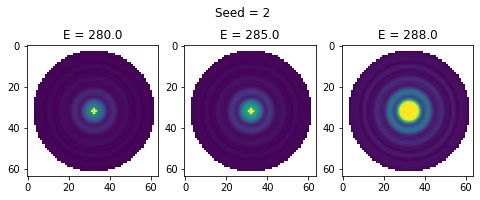

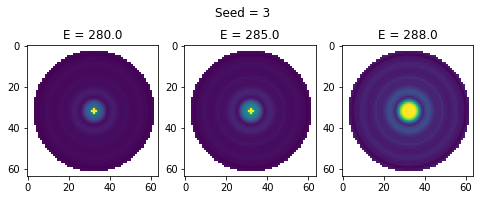

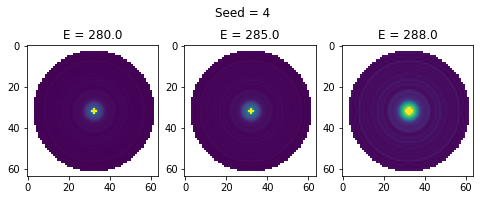

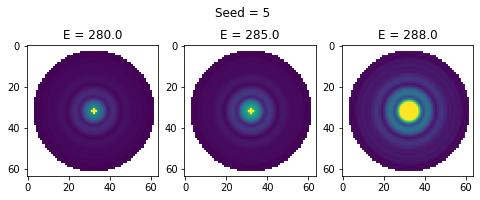

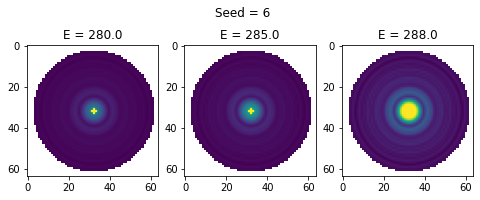

In [13]:
# create the objects to use - these will be reused by multiple simulations.
voxels2 = runner2.make_voxel_object()
scattering2 = runner2.make_scattering_object()

for seed in range(2, 7):
    # create new morphology
    np.random.seed(seed)
    temp_morphology = np.random.random(size=system_size2)
    # Add contrast. Not needed, but it makes patterns interesting
    b1, b2, _ = [dim // 6 for dim in system_size2]
    temp_morphology[:b1,:b2,:] = np.random.vonmises(seed, 100,
                                                    size=(b1,b2,system_size2[2]))

    # fill in the voxel object
    set_voxels(temp_morphology, voxels2)

    # run the simulation
    runner2.run(voxels2, scattering2, stdout=False, stderr=False, is_batch=True)

    # show result
    fig, ax = plt.subplots(1, len(energies2), figsize=(8,3))
    fig.suptitle("Seed = " + str(seed))
    for i, energy in enumerate(energies2):
        ax[i].imshow(np.log(scattering2.dataToNumpy(energy)), vmax=np.log(1e-1))
        ax[i].set_title("E = " + str(energy))
    plt.show()